In [26]:
!pip install tensorflow keras opencv-python


In [27]:
!pip install --quiet opencv-python matplotlib tqdm


In [28]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


In [29]:
IMAGE_DIR = "/kaggle/input/brain-tumor-for-segmentation/Brain tumor segmentation"
MASK_DIR  = "/kaggle/working/masks"

os.makedirs(MASK_DIR, exist_ok=True)

print("Images Path:", IMAGE_DIR)
print("Mask Save Path:", MASK_DIR)


Images Path: /kaggle/input/brain-tumor-for-segmentation/Brain tumor segmentation
Mask Save Path: /kaggle/working/masks


In [30]:
def mri_to_mask(img_path):
    # Read image (grayscale)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    # Resize (optional but recommended)
    img = cv2.resize(img, (512, 512))
    
    # Noise reduction
    blur = cv2.GaussianBlur(img, (5, 5), 0)
    
    # Otsu Threshold
    _, mask = cv2.threshold(
        blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )
    
    # Morphological cleaning
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    return img, mask


In [31]:
image_files = os.listdir(IMAGE_DIR)

for img_name in tqdm(image_files):
    img_path = os.path.join(IMAGE_DIR, img_name)

    img, mask = mri_to_mask(img_path)

    save_path = os.path.join(MASK_DIR, img_name)
    cv2.imwrite(save_path, mask)

print("✅ All masks generated and saved successfully!")


100%|██████████| 955/955 [00:06<00:00, 155.58it/s]

✅ All masks generated and saved successfully!


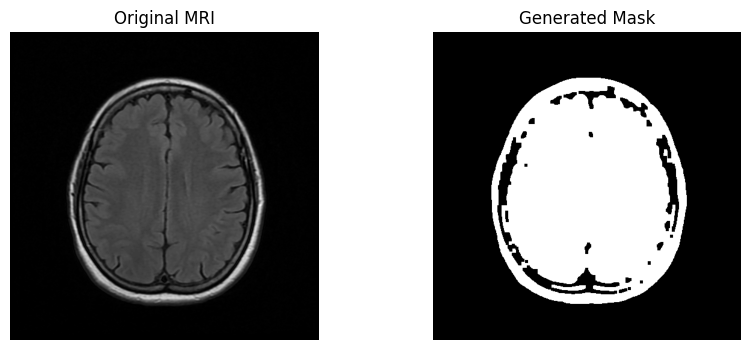

In [32]:
sample_img = image_files[0]
img_path = os.path.join(IMAGE_DIR, sample_img)

img, mask = mri_to_mask(img_path)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.title("Original MRI")
plt.imshow(img, cmap='gray')
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Generated Mask")
plt.imshow(mask, cmap='gray')
plt.axis("off")

plt.show()


In [33]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate


In [34]:
!git clone https://huggingface.co/datasets/kowndinya23/Kvasir-SEG


fatal: destination path 'Kvasir-SEG' already exists and is not an empty directory.


In [35]:
image_dir = '/kaggle/input/brain-tumor-for-segmentation/Brain tumor segmentation'
mask_dir = '/kaggle/working/masks'

images = []
masks = []

for img_name in os.listdir(image_dir):
    img = cv2.imread(os.path.join(image_dir, img_name))
    img = cv2.resize(img, (128, 128))  # Resize to fit model input
    images.append(img)

    mask = cv2.imread(os.path.join(mask_dir, img_name), cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (128, 128))
    masks.append(mask)

images = np.array(images) / 255.0  # Normalize images
masks = np.array(masks) / 255.0     # Normalize masks


In [36]:
def unet_model(input_size=(128, 128, 3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = concatenate([up6, conv4])
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = concatenate([up7, conv3])
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = concatenate([up8, conv2])
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    up9 = concatenate([up9, conv1])
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [37]:
model.fit(images, masks.reshape(-1, 128, 128, 1), epochs=50)


Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 17s 293ms/step - accuracy: 0.6813 - loss: 0.5460
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step - accuracy: 0.8817 - loss: 0.1620
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step - accuracy: 0.8992 - loss: 0.0877
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step - accuracy: 0.8941 - loss: 0.0905
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step - accuracy: 0.8948 - loss: 0.0900
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step - accuracy: 0.8946 - loss: 0.0915
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step - accuracy: 0.8963 - loss: 0.0859
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step - accuracy: 0.8954 - loss: 0.0897
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step - accuracy: 0.8994 - loss: 0.0781
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step - accuracy: 0.8977 - loss: 0.0785
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step - accuracy: 0.8972 - loss: 0.0782
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/ste

In [41]:
test_image_path = '/kaggle/input/brain-tumor-for-segmentation/Brain tumor segmentation/1 (1).jpg'
test_image = cv2.imread(test_image_path)

# Get original dimensions
original_height_of_test_image, original_width_of_test_image = test_image.shape[:2]

# Resize the test image for model input
test_image_resized = cv2.resize(test_image, (128, 128)) / 255.0
test_image_input = np.expand_dims(test_image_resized, axis=0)  # Add batch dimension

# Predict the mask
predicted_mask = model.predict(test_image_input)[0]

# Resize predicted mask to original dimensions
predicted_mask_resized = cv2.resize(predicted_mask.squeeze(), (original_width_of_test_image, original_height_of_test_image))

# Convert predicted mask to uint8 for visualization
predicted_mask_resized_uint8 = (predicted_mask_resized * 255).astype(np.uint8)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


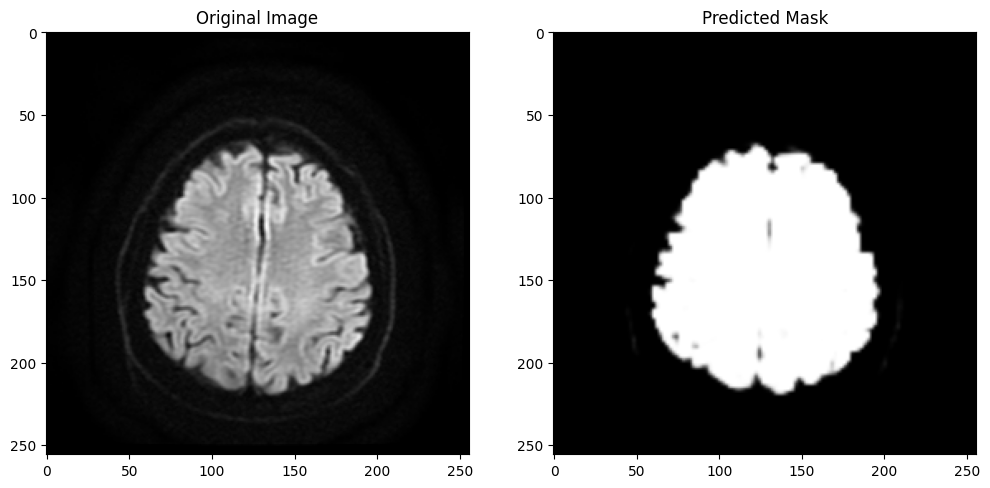

In [42]:
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display

# Predicted Mask
plt.subplot(1, 2, 2)
plt.title("Predicted Mask")
plt.imshow(predicted_mask_resized_uint8, cmap="gray")  # Display mask as grayscale

plt.show()



In [43]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def calculate_accuracy(original_mask_path, predicted_mask_path):
    # Load original mask and predicted mask
    original_mask = cv2.imread(original_mask_path, cv2.IMREAD_GRAYSCALE)
    predicted_mask = predicted_mask_resized_uint8

    # Ensure masks are binary (0 or 255)
    _, original_mask_binary = cv2.threshold(original_mask, 127, 255, cv2.THRESH_BINARY)
    _, predicted_mask_binary = cv2.threshold(predicted_mask, 127, 255, cv2.THRESH_BINARY)

    # Calculate pixel accuracy
    correct_pixels = np.sum(original_mask_binary == predicted_mask_binary)
    total_pixels = original_mask_binary.size
    accuracy_percentage = (correct_pixels / total_pixels) * 100

    return accuracy_percentage, original_mask_binary, predicted_mask_binary

# Specify paths to your images
original_image_path = '/kaggle/input/brain-tumor-for-segmentation/Brain tumor segmentation/1 (1).jpg'  # Path to original image (for visualization)
original_mask_path = '/kaggle/working/masks/1 (1).jpg'    # Path to ground truth mask
predicted_mask_path = predicted_mask_resized_uint8  # Path to predicted mask

# Calculate accuracy
accuracy_percentage, original_mask, predicted_mask = calculate_accuracy(original_mask_path, predicted_mask_path)

# Load original image for visualization
original_image = cv2.imread(original_image_path)

# Display results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Ground Truth Mask")
plt.imshow(original_mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(predicted_mask, cmap='gray')
plt.axis('off')

plt.suptitle(f'Accuracy: {accuracy_percentage:.2f}%', fontsize=16)
plt.tight_layout()
plt.show()


ValueError: operands could not be broadcast together with shapes (512,512) (256,256) 